In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilities import compute_fingerprints
from dataUtils import DataUtils as utils
from model_utils import ModelUtils as mutls

C:\Users\Yang\.conda\envs\test_speedcom\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
from keras import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Conv1D, Activation

Using TensorFlow backend.


In [3]:
from sklearn import metrics

In [4]:
df = pd.read_csv('cleaned_data_emission.tsv', sep='\t')

In [5]:
df.head()

,#,Name,Epsilon,Solvent,Quantum Yield,Solvent.1,File,File.1,Absorption,SMILES,Emission
0,1,Benzene,210,cyclohexane,0.053,hexane,A01_71-43-2_Benzene.abs.txt,A01_71-43-2_Benzene.ems.txt,254.75,C1=CC=CC=C1,287.0
1,2,Toluene,2860,cyclohexane,0.170,cyclohexane,A02_108-88-3_Toluene.abs.txt,A02_108-88-3_Toluene.ems.txt,261.75,CC1=CC=CC=C1,289.5
2,3,o-Xylene,254,cyclohexane,0.170,hexane,A03_95-47-6_o-Xylene.abs.txt,A03_95-47-6_o-Xylene.ems.txt,263.00,CC1=CC=CC=C1C,291.0
3,4,m-Xylene,284,cyclohexane,0.130,hexane,A04_108-38-3_m-Xylene.abs.txt,A04_108-38-3_m-Xylene.ems.txt,265.00,CC1=CC(=CC=C1)C,290.0
4,5,p-Xylene,770,cyclohexane,0.220,hexane,A05_106-42-3_p-Xylene.abs.txt,A05_106-42-3_p-Xylene.ems.txt,275.00,CC1=CC=C(C=C1)C,291.0


In [6]:
df['cfp']=pd.Series(compute_fingerprints(df=df,SMILES_column='SMILES'))

In [7]:
X_fp=np.array(list(map(np.array, df['cfp'])))

In [8]:
Y = df.values[:,8]

### First model original Y

In [9]:
d_cat = mutls.combine_columns((X_fp, Y))

In [10]:
X, y = d_cat[:,0:-1], d_cat[:,-1]

In [11]:
X_train, X_test, y_train, y_test = utils.splitData(X, y, ratio=0.20)
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(232, 137)
(59, 137)
(232, 1)
(59, 1)


In [12]:
unique_int_counts = len(np.unique(X_train))

In [13]:
word_range = np.unique(X_train).max()-np.unique(X_train).min()+1

In [14]:
word_range

256

In [15]:
X_train.shape

(232, 137)

In [16]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout, Flatten, BatchNormalization

In [23]:
hidden_size = 50
model = Sequential()
model.add(Embedding(word_range, hidden_size, input_length= X.shape[1]))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(Dense(hidden_size, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mean_absolute_error'])
model.summary() ##use mean_squared_error loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 137, 50)           12800     
_________________________________________________________________
lstm_7 (LSTM)                (None, 137, 50)           20200     
_________________________________________________________________
batch_normalization_3 (Batch (None, 137, 50)           200       
_________________________________________________________________
lstm_8 (LSTM)                (None, 137, 50)           20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 137, 50)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 137, 50)           20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 137, 50)           0         
__________

In [24]:
history=model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=100)

Train on 232 samples, validate on 59 samples
Epoch 1/100
232/232 [==============================] - 5s 20ms/step - loss: 156827.3852 - mean_absolute_error: 369.3423 - val_loss: 158844.5278 - val_mean_absolute_error: 370.6534
Epoch 2/100
232/232 [==============================] - 1s 6ms/step - loss: 145141.8895 - mean_absolute_error: 353.2318 - val_loss: 141157.0697 - val_mean_absolute_error: 346.1699
Epoch 3/100
232/232 [==============================] - 1s 6ms/step - loss: 117478.3497 - mean_absolute_error: 310.5162 - val_loss: 104202.2090 - val_mean_absolute_error: 287.7517
Epoch 4/100
232/232 [==============================] - 1s 6ms/step - loss: 76167.2136 - mean_absolute_error: 234.5864 - val_loss: 53542.3568 - val_mean_absolute_error: 180.2285
Epoch 5/100
232/232 [==============================] - 1s 6ms/step - loss: 34824.3450 - mean_absolute_error: 133.5501 - val_loss: 21864.8775 - val_mean_absolute_error: 118.8899
Epoch 6/100
232/232 [==============================] - 1s 6ms/s

232/232 [==============================] - 2s 7ms/step - loss: 663.2883 - mean_absolute_error: 20.3525 - val_loss: 13599.3397 - val_mean_absolute_error: 86.8000
Epoch 95/100
232/232 [==============================] - 2s 7ms/step - loss: 615.2195 - mean_absolute_error: 18.9423 - val_loss: 14989.9076 - val_mean_absolute_error: 87.8952
Epoch 96/100
232/232 [==============================] - 2s 7ms/step - loss: 806.8308 - mean_absolute_error: 21.6918 - val_loss: 13905.4676 - val_mean_absolute_error: 87.4088
Epoch 97/100
232/232 [==============================] - 2s 7ms/step - loss: 637.6210 - mean_absolute_error: 18.6725 - val_loss: 13919.6097 - val_mean_absolute_error: 88.1893
Epoch 98/100
232/232 [==============================] - 2s 7ms/step - loss: 589.5571 - mean_absolute_error: 17.9295 - val_loss: 13954.8239 - val_mean_absolute_error: 87.7408
Epoch 99/100
232/232 [==============================] - 2s 7ms/step - loss: 661.3787 - mean_absolute_error: 19.8550 - val_loss: 14867.3002 - va

In [25]:
metrics.r2_score(y_train, model.predict(X_train))

0.9332704540803308

In [26]:
metrics.r2_score(y_test, model.predict(X_test))

0.34719905757714975

In [29]:
metrics.mean_absolute_error(y_train, model.predict(X_train))

30.94836088509395

In [30]:
metrics.mean_absolute_error(y_test, model.predict(X_test))

89.20522657491394

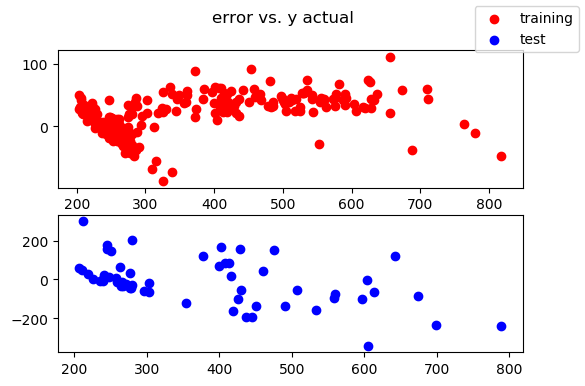

In [28]:
mutls.plot_model_error(X_train,X_test,y_train, y_test, model)

Overfitting problem

### Second model, category model

In [31]:
Y_category = mutls.get_y_category(y_actual=Y, min_edge=200, bin_width=20)

In [32]:
cls_counts = mutls.get_class_count(Y_category)

In [33]:

print(cls_counts)

{0.0: 18, 1.0: 23, 2.0: 42, 3.0: 44, 4.0: 14, 5.0: 8, 6.0: 8, 7.0: 6, 8.0: 6, 9.0: 3, 10.0: 21, 11.0: 12, 12.0: 7, 13.0: 5, 14.0: 7, 15.0: 12, 16.0: 8, 17.0: 10, 18.0: 5, 19.0: 6, 20.0: 7, 21.0: 6, 22.0: 3, 23.0: 2, 24.0: 2, 25.0: 2, 28.0: 1, 29.0: 2, 30.0: 1}


In [34]:
X_fp.shape

(291, 137)

In [35]:
d_cat = mutls.combine_columns((X_fp, Y_category))

In [36]:
subsampled=mutls.subsampling(d_cat,-1,15,cls_counts)

In [37]:
subsampled

array([[224, 255, 255, ..., 0, 0, 3.0],
       [224, 255, 255, ..., 0, 0, 1.0],
       [224, 255, 255, ..., 0, 0, 1.0],
       ...,
       [224, 255, 255, ..., 0, 0, 10.0],
       [224, 255, 255, ..., 0, 0, 10.0],
       [224, 255, 255, ..., 0, 0, 29.0]], dtype=object)

In [38]:
X, y = subsampled[:,0:-1], subsampled[:,-1]
y_onehot = mutls.onehot_encode_y(y=y, num_class=31)
X_train, X_test, y_train, y_test = utils.splitData(X, y_onehot, ratio=0.10)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(198, 137)
(23, 137)
(198, 31)
(23, 31)


### 2nd fingerprint model RNN LSTM with category Y

In [39]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

rnn1_size = 224
rnn2_size = 384
dropout_rate = 0.2
loss = 'categorical_crossentropy'
metrics = ['accuracy']
num_classes = 31
optimizer = 'adam' #use adam optimizer

model_1 = Sequential()
model_1.add(LSTM(rnn1_size, return_sequences=True, input_shape=(137,1))) #137
model_1.add(LSTM(rnn2_size))
model_1.add(Dense(num_classes, activation='softmax'))
model_1.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 137, 224)          202496    
_________________________________________________________________
lstm_11 (LSTM)               (None, 384)               935424    
_________________________________________________________________
dense_7 (Dense)              (None, 31)                11935     
Total params: 1,149,855
Trainable params: 1,149,855
Non-trainable params: 0
_________________________________________________________________


In [40]:
batch_size = 16
epochs = 100

model_1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=[X_test, y_test])

Train on 198 samples, validate on 23 samples
Epoch 1/100
198/198 [==============================] - 13s 66ms/step - loss: 3.3612 - acc: 0.0758 - val_loss: 3.2490 - val_acc: 0.1304
Epoch 2/100
198/198 [==============================] - 10s 48ms/step - loss: 3.1814 - acc: 0.1010 - val_loss: 3.2949 - val_acc: 0.1304
Epoch 3/100
198/198 [==============================] - 10s 50ms/step - loss: 3.1683 - acc: 0.0657 - val_loss: 3.1966 - val_acc: 0.1304
Epoch 4/100
198/198 [==============================] - 10s 48ms/step - loss: 3.0996 - acc: 0.1010 - val_loss: 3.1908 - val_acc: 0.1304
Epoch 5/100
198/198 [==============================] - 10s 52ms/step - loss: 3.0847 - acc: 0.0707 - val_loss: 3.1931 - val_acc: 0.0870
Epoch 6/100
198/198 [==============================] - 11s 56ms/step - loss: 2.9649 - acc: 0.0859 - val_loss: 3.3290 - val_acc: 0.1304
Epoch 7/100
198/198 [==============================] - 11s 56ms/step - loss: 3.0059 - acc: 0.1263 - val_loss: 3.0711 - val_acc: 0.1304
Epoch 8/10

Epoch 61/100
198/198 [==============================] - 10s 50ms/step - loss: 2.2616 - acc: 0.2172 - val_loss: 3.6083 - val_acc: 0.1304
Epoch 62/100
198/198 [==============================] - 10s 50ms/step - loss: 2.2407 - acc: 0.2071 - val_loss: 3.8918 - val_acc: 0.1304
Epoch 63/100
198/198 [==============================] - 10s 50ms/step - loss: 2.3646 - acc: 0.2071 - val_loss: 3.6174 - val_acc: 0.1739
Epoch 64/100
198/198 [==============================] - 10s 50ms/step - loss: 2.2728 - acc: 0.2475 - val_loss: 3.8676 - val_acc: 0.1739
Epoch 65/100
198/198 [==============================] - 10s 50ms/step - loss: 2.2915 - acc: 0.2525 - val_loss: 3.8807 - val_acc: 0.0870
Epoch 66/100
198/198 [==============================] - 10s 50ms/step - loss: 2.3428 - acc: 0.2172 - val_loss: 3.6339 - val_acc: 0.1739
Epoch 67/100
198/198 [==============================] - 10s 50ms/step - loss: 2.3718 - acc: 0.2273 - val_loss: 3.7439 - val_acc: 0.1304
Epoch 68/100
198/198 [==========================

Training acc 0.27, testing accuracy 0.26, 30 classes (each class )